In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from transformers import VivitImageProcessor, VivitForVideoClassification
import pytorchvideo.data
from transformers import TrainingArguments, Trainer
import evaluate
import torch
import torch, gc
from transformers import pipeline
from transformers import ViTImageProcessor
import numpy as np
from torch.utils.data import ChainDataset

# **Video Classification - ViViT**

In [3]:
# Transformers installation
! pip install transformers datasets # 세션 다시 시작 후 안돌려도 됨
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

In [4]:
!pip install -q pytorchvideo transformers evaluate # 세션 다시 시작 후 안돌려도 됨

In [5]:
!pip install accelerate -U # 이거 돌리고 세션 다시 시작

In [6]:
from huggingface_hub import notebook_login

notebook_login()

## dataset 구조 변경



At a high level, the dataset is organized like so:

```bash
temp/
    train/
        가렵다/
            video_1.mp4
            video_2.mp4
            ...
        골절
            video_1.mp4
            video_2.mp4
            ...
        ...
    val/
        가렵다/
            video_1.mp4
            video_2.mp4
            ...
        골절
            video_1.mp4
            video_2.mp4
            ...
        ...
    test/
        가렵다/
            video_1.mp4
            video_2.mp4
            ...
        골절
            video_1.mp4
            video_2.mp4
            ...
        ...
```

* `label2id`: maps the class names to integers.
* `id2label`: maps the integers to class names.

In [7]:
import os
import re
import shutil

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# all = os.listdir('/content/drive/MyDrive/기컴비_텀프/data/original_mediapipe')
# {i.split('_')[1] for i in all}
# # 01, 02, 03, 04, 06, 08 -> Train
# # 05, 09 -> Val
# # 07, 16 -> Test

In [9]:
# train_num = ['01','02','03','04','06','08']
# val_num = ['05','09']
# test_num = ['07','16']

In [10]:
from tqdm import tqdm

In [11]:
# # 작업 디렉터리 설정하기(data/train_dataset/)
# base_dir = '/content/drive/MyDrive/기컴비_텀프/data'
# from_dir = os.path.join(base_dir,'original_mediapipe')
# to_dir = os.path.join(base_dir,'train_dataset/original_mediapipe')

# # 파일을 분류할 디렉터리들 생성하기
# os.makedirs(os.path.join(to_dir, 'train'), exist_ok=True)
# os.makedirs(os.path.join(to_dir, 'val'), exist_ok=True)
# os.makedirs(os.path.join(to_dir, 'test'), exist_ok=True)

# for file_name in tqdm(all):
#     # 숫자 접두어와 라벨 분리하기
#     prefix = file_name.split('_')[1] #사람번호
#     label = file_name.split('_')[3].split('.')[0] #단어뜻(label)

#     # 라벨 별로 디렉터리 생성하기
#     if prefix in train_num:
#         dest_dir = os.path.join(to_dir, 'train', label)
#     elif prefix in val_num:
#         dest_dir = os.path.join(to_dir, 'val', label)
#     elif prefix in test_num:
#         dest_dir = os.path.join(to_dir, 'test', label)
#     else:
#         continue

#     os.makedirs(dest_dir, exist_ok=True)

#     # 파일을 적절한 디렉터리로 이동하기
#     shutil.copy(os.path.join(from_dir, file_name), os.path.join(dest_dir, file_name))

# print("파일 분류 작업을 완료하였습니다.")


## Load a model to fine-tune

In [12]:
import os
class_labels = sorted(set(os.listdir('/content/drive/MyDrive/CV/기컴비_텀프/data/train_dataset/original/train')))
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

In [13]:
print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['가렵다', '골절', '구급차', '다리', '배고프다', '병원', '붕대', '쓰러지다', '의사', '친구'].


In [14]:
from transformers import VivitImageProcessor, VivitForVideoClassification

model_ckpt = 'google/vivit-b-16x2-kinetics400'
image_processor = VivitImageProcessor.from_pretrained(model_ckpt)
model = VivitForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of VivitForVideoClassification were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized because the shapes did not match:
- classifie

## Prepare the datasets for training

For preprocessing the videos, you will leverage the [PyTorchVideo library](https://pytorchvideo.org/). Start by importing the dependencies we need.

In [15]:
import pytorchvideo.data

# augmentations.py (functional_tensor->_functional_tensor)
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

For the training dataset transformations, use a combination of uniform temporal subsampling, pixel normalization, random cropping, and random horizontal flipping. For the validation and evaluation dataset transformations, keep the same transformation chain except for random cropping and horizontal flipping. To learn more about the details of these transformations check out the [official documentation of PyTorchVideo](https://pytorchvideo.org).  

Use the `image_processor` associated with the pre-trained model to obtain the following information:

* Image mean and standard deviation with which the video frame pixels will be normalized.
* Spatial resolution to which the video frames will be resized.

Start by defining some constants.

In [16]:
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

Now, define the dataset-specific transformations and the datasets respectively. Starting with the training set:

In [17]:
# train_transform = Compose(
#     [
#         ApplyTransformToKey(
#             key="video",
#             transform=Compose(
#                 [
#                     UniformTemporalSubsample(num_frames_to_sample),
#                     Lambda(lambda x: x / 255.0),
#                     Normalize(mean, std),
#                     # RandomShortSideScale(min_size=256, max_size=320),
#                     Resize(resize_to)
#                     # RandomHorizontalFlip(p=0.5),
#                 ]
#             ),
#         ),
#     ]
# )

# dataset_root_path = '/content/drive/MyDrive/기컴비_텀프/data/train_dataset/original_mediapipe'

# train_dataset = pytorchvideo.data.labeled_video_dataset(
#     data_path=os.path.join(dataset_root_path, "train"),
#     clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
#     decode_audio=False,
#     transform=train_transform,
# )

In [18]:
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    # RandomShortSideScale(min_size=256, max_size=320),
                    Resize(resize_to)
                    # RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

dataset_root_path1 = '/content/drive/MyDrive/CV/기컴비_텀프/data/train_dataset/original'
dataset_root_path2 = '/content/drive/MyDrive/CV/기컴비_텀프/data/train_dataset/original_mediapipe'

train_dataset1 = pytorchvideo.data.labeled_video_dataset(
    data_path=os.path.join(dataset_root_path1, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

train_dataset2 = pytorchvideo.data.labeled_video_dataset(
    data_path=os.path.join(dataset_root_path2, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

train_dataset = ChainDataset([train_dataset1, train_dataset2])


The same sequence of workflow can be applied to the validation and evaluation sets:

In [19]:
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

val_dataset1 = pytorchvideo.data.labeled_video_dataset(
    data_path=os.path.join(dataset_root_path1, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

val_dataset2 = pytorchvideo.data.labeled_video_dataset(
    data_path=os.path.join(dataset_root_path2, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

val_dataset = ChainDataset([val_dataset1, val_dataset2])

test_dataset1 = pytorchvideo.data.labeled_video_dataset(
    data_path=os.path.join(dataset_root_path1, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset2 = pytorchvideo.data.labeled_video_dataset(
    data_path=os.path.join(dataset_root_path2, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = ChainDataset([test_dataset1, test_dataset2])


In [20]:
print(train_dataset1.num_videos, val_dataset1.num_videos, test_dataset1.num_videos)
print(train_dataset2.num_videos, val_dataset2.num_videos, test_dataset2.num_videos)

300 100 100
300 100 100


## Visualize the preprocessed video for better debugging

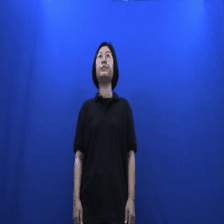

In [21]:
import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

sample_video = next(iter(train_dataset))
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [22]:
for i in iter(train_dataset):
    break

In [23]:
i['video'][:,0,:,:].shape

torch.Size([3, 224, 224])

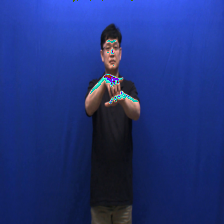

In [24]:
from torchvision.transforms import ToPILImage

tf =ToPILImage()
img = tf(i['video'][:,13,:,:])
img

## Train the model

Leverage [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) from  🤗 Transformers for training the model. To instantiate a `Trainer`, you need to define the training configuration and an evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to configure the training. It requires an output folder name, which will be used to save the checkpoints of the model. It also helps sync all the information in the model repository on 🤗 Hub.

Most of the training arguments are self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in this case, you need the unused features ('video' in particular) in order to create `pixel_values` (which is a mandatory key our model expects in its inputs).

In [25]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-0515-training-O_OM"
num_epochs = 10
batch_size = 2

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    max_steps=((train_dataset1.num_videos+train_dataset2.num_videos) // batch_size) * num_epochs,
)

The dataset returned by `pytorchvideo.data.Ucf101()` doesn't implement the `__len__` method. As such, we must define `max_steps` when instantiating `TrainingArguments`.

Next, you need to define a function to compute the metrics from the predictions, which will use the `metric` you'll load now. The only preprocessing you have to do is to take the argmax of our predicted logits:

In [26]:
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

**A note on evaluation**:

In the [VideoMAE paper](https://arxiv.org/abs/2203.12602), the authors use the following evaluation strategy. They evaluate the model on several clips from test videos and apply different crops to those clips and report the aggregate score. However, in the interest of simplicity and brevity, we don't consider that in this tutorial.

Also, define a `collate_fn`, which will be used to batch examples together. Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [27]:
import torch

In [28]:
def collate_fn(examples):
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then you just pass all of this along with the datasets to `Trainer`:

In [29]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

max_steps is given, it will override any value given in num_train_epochs


You might wonder why you passed along the `image_processor` as a tokenizer when you preprocessed the data already. This is only to make sure the image processor configuration file (stored as JSON) will also be uploaded to the repo on the Hub.

Now fine-tune our model by calling the `train` method:

In [30]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss


Once training is completed, share your model to the Hub with the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method so everyone can use your model:

In [ ]:
trainer.push_to_hub()

## Inference

Great, now that you have fine-tuned a model, you can use it for inference!

Load a video for inference:

In [ ]:
from transformers import pipeline
from transformers import ViTImageProcessor

image_processor = VivitImageProcessor.from_pretrained("std50218/vivit-b-16x2-kinetics400-0511-training-original_mediapipe")

video_cls = pipeline(model="std50218/vivit-b-16x2-kinetics400-0511-training-original_mediapipe")
video_cls.image_processor = image_processor

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/355M [00:00<?, ?B/s]

In [ ]:
video_cls.model.config.id2label

In [ ]:
video_cls("/content/drive/MyDrive/기컴비_텀프/data/train_dataset/mediapipe/test/붕대/M_07_F_붕대.mp4")

[{'score': 0.2084958702325821, 'label': '배고프다'},
 {'score': 0.16527754068374634, 'label': '골절'},
 {'score': 0.12434286624193192, 'label': '쓰러지다'},
 {'score': 0.10763990134000778, 'label': '가렵다'},
 {'score': 0.09598082304000854, 'label': '의사'}]